# RDP_ML_Binary

In [1]:
import datetime
import os
import numpy as np
import pandas as pd
from pathlib import PurePath
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers, Model, optimizers, initializers, metrics, losses
from tensorflow.keras.optimizers import schedules
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Dropout, Conv1D, AveragePooling1D, Input, Dense, MaxPool1D, GlobalMaxPool1D, MaxPooling1D
from tensorflow.keras.optimizers import schedules, Adam, SGD, Nadam
from tensorflow.keras.losses import SparseCategoricalCrossentropy,  BinaryCrossentropy
from tensorflow.keras.activations import softmax
from tensorflow.keras.models import Model, load_model

from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from tensorflow.keras.losses import BinaryCrossentropy
from tools import class_report, ingestor
import re

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import textwrap

from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.layers import LayerNormalization, Add, BatchNormalization
from tensorflow.keras.regularizers import l1_l2, l1, l2

from tensorflow.keras.utils import plot_model

from tools import class_report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, RocCurveDisplay

2025-01-28 11:26:10.437642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738056370.458027  588450 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738056370.463813  588450 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-28 11:26:10.484136: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Data should already be created from the RDPML.ipynb file. This file has the initial data code (after the pipelines have been run as described in file description section on github)

In [3]:
# Input Data from saved File
X_train = pd.read_csv('dataParsed_test/Train.csv', index_col=False)
X_test = pd.read_csv('dataParsed_test/Test.csv', index_col=False)
X_unseen = pd.read_csv("dataParsed_test/Unseen.csv", index_col=False)

In [4]:
#Drop Consensus metrics
X_train = X_train.drop(
    columns=['Consensus(A:0)', 'Consensus(A:1)', 'Consensus(A:2)'])
X_test = X_test.drop(
    columns=['Consensus(A:0)', 'Consensus(A:1)', 'Consensus(A:2)'])
X_unseen = X_unseen.drop(
    columns=['Consensus(A:0)', 'Consensus(A:1)', 'Consensus(A:2)'])


#Rename Some features for ease of use later
def z(x): return x.replace("(", "").replace(")", "").replace(":", "_").replace(
    " ", "_")

X_train.columns = pd.Series(X_train.columns).apply(z)
X_test.columns = pd.Series(X_test.columns).apply(z)
X_unseen.columns = pd.Series(X_unseen.columns).apply(z)

# Create response variables
y_train = X_train.pop("is_recombinant").astype(np.int64)
y_test = X_test.pop("is_recombinant").astype(np.int64)
y_unseen = X_unseen.pop("is_recombinant").astype(np.int64)

print(f'Number of training samples: {X_train.shape[0]} \n')

Number of training samples: 464505 



In [5]:
# Scale inputs using standard scaler
Scale = StandardScaler()
Scale.fit(X_train)

X_train = pd.DataFrame(Scale.transform(X_train),
                       index=X_train.index,
                       columns=X_train.columns)
X_test = pd.DataFrame(Scale.transform(X_test),
                      index=X_test.index,
                      columns=X_train.columns)
X_unseen = pd.DataFrame(Scale.transform(X_unseen),
                      index=X_unseen.index,
                      columns=X_train.columns)


In [6]:
# Drop data with no variance - won't contribute to learning
VT = VarianceThreshold()
X_vt = VT.fit(X_train)
variance_mask = X_vt.get_support()
print('\nDropping these features that do not show any variance:')
print(X_train.columns[~variance_mask].values)

X_train = pd.DataFrame(VT.transform(X_train),
                       columns=X_train.columns[variance_mask], index=X_train.index)
X_test = pd.DataFrame(VT.transform(X_test),
                      columns=X_test.columns[variance_mask], index=X_test.index)
X_unseen = pd.DataFrame(VT.transform(X_unseen),
                      columns=X_unseen.columns[variance_mask], index=X_unseen.index)

input_size =  len(X_train.columns)
print(f'\nKeeping these {input_size} features')
print(X_train.columns.values)


Dropping these features that do not show any variance:
['SRCompatFA' 'SRCompatSA' 'RCompatXFA' 'RCompatXSA' 'SetTot1_A']

Keeping these 32 features
['ListCorrA' 'SimScoreBA' 'SimScoreA' 'PhPrScoreA' 'PhPrScore2A'
 'PhPrScore3A' 'SubScoreA' 'SSDistA' 'OUIndexAA' 'SubPhPrScoreA'
 'SubScore2A' 'SubPhPrScore2A' 'RCompatA' 'RCompat2A' 'RCompat3A'
 'RCompat4A' 'RCompatSA' 'RCompatS2A' 'RCompatS3A' 'RCompatS4A'
 'RCompatCA' 'RCompatDA' 'TrpScoreA' 'BadDistsA' 'OUListA' 'ListCorr2A'
 'ListCorr3A' 'OuCheckA' 'SetTot0_A' 'RankFA_0' 'RankFA_1' 'dMaxA']


In [7]:
#Calculate class Weights from Sklearn for training

cw = class_weight.compute_class_weight(class_weight='balanced',
                                       classes=np.unique(y_train),
                                       y=y_train.values)
class_weights = {0: cw[0], 1: cw[1]}
# class_weights = {0: 0.3, 1: 0.7}
print('class weights:', class_weights)

class weights: {0: np.float64(0.75), 1: np.float64(1.5)}


In [8]:
#Create Datasets
X_train = tf.convert_to_tensor(X_train.values, dtype='float32')
y_train = tf.convert_to_tensor(y_train.values, dtype='int32')
                          
X_test = tf.convert_to_tensor(X_test.values, dtype='float32')
y_test = tf.convert_to_tensor(y_test.values, dtype='int32')

X_unseen = tf.convert_to_tensor(X_unseen.values, dtype='float32')
y_unseen = tf.convert_to_tensor(y_unseen.values, dtype='int32')

I0000 00:00:1738056404.086335  588450 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:26:00.0, compute capability: 8.6


In [9]:
# Do we have GPU
print("TensorFlow version:", tf.__version__)
print("TF is built with cuda: ", tf.test.is_built_with_cuda())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.18.0
TF is built with cuda:  True
Num GPUs Available:  1


# Define Standard Figures

In [10]:
def StdConfMatrix(y_true, y_pred, normalise=None, format='.6g', figure_number=None):
    # Create figure
    fig = plt.figure(figsize=(9, 9))
    
    if figure_number is not None:
        # Create a small subplot for the figure number (top left)
        ax_number = fig.add_axes([0.01, 0.92, 0.01, 0.002])  # [left, bottom, width, height]
        ax_number.axis('off')  # Hide axis
        ax_number.text(0, 0.5, f'{figure_number}',
                      fontsize=14,
                      fontweight='semibold',
                      style='italic',
                      horizontalalignment='left',
                      verticalalignment='center')
    
    # Create main subplot for the confusion matrix
    ax_main = fig.add_axes([0.1, 0.1, 0.85, 0.85])  # [left, bottom, width, height]
    
    # Create and display confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true=y_true,
        y_pred=y_pred,
        normalize=normalise,
        cmap='PuBu',
        values_format=format,
        display_labels=["Parent", "Recombinant"],
        text_kw={'size': 14},
        colorbar=False,
        ax=ax_main  # Pass the main axis to plot on
    )
    
    plt.colorbar(disp.im_, ax=ax_main, shrink=0.8, pad=0.05)

    # Customize the plot
    ax_main.set_title('Confusion Matrix', pad=20, size=18)  # Title Size
    
    # Adjust label sizes
    ax_main.set_xlabel('Predicted', fontsize=14)  # X-axis label size
    ax_main.set_ylabel('True', fontsize=14)       # Y-axis label size
    
    # Adjust tick sizes, rotation, and padding
    ax_main.tick_params(axis='x', labelsize=12, pad=10)  # x-axis padding
    ax_main.tick_params(axis='y', labelsize=12, pad=10)  # y-axis padding
    
    # Rotate and align y-axis labels
    ax_main.set_yticklabels(
        ax_main.get_yticklabels(),
        rotation=90,
        va='center',  # Vertical alignment
        ha='center'   # Horizontal alignment
    )
    
    # Return the display object and main axis for further customization if needed
    return disp, ax_main



def StdRocCurve(y_true, y_probs_list, model_names=None, auc_decimals=4, figure_number=None, 
                colors=None, figsize=(9, 9)):
    """
    Plot multiple ROC curves on the same figure.
    
    Parameters:
    -----------
    y_true : array-like
        True binary labels
    y_probs_list : list of array-like
        List of probability estimates for each model
    model_names : list of str, optional
        Names for each model (default: ["Model 1", "Model 2", ..., "Model n"])
    auc_decimals : int, optional
        Number of decimals to display in AUC scores (default: 4)
    figure_number : int, optional
        Figure number to display in top left corner
    colors : list of str or None, optional
        Colors for each ROC curve. If None, uses a color map
    figsize : tuple, optional
        Figure size in inches (default: (9, 9))
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    ax_main : matplotlib.axes.Axes
        The main axes object
    """
    # Validate inputs
    if not isinstance(y_probs_list, list):
        y_probs_list = [y_probs_list]
    
    n_models = len(y_probs_list)
    
    # Set default model names if not provided
    if model_names is None:
        model_names = [f"Model {i+1}" for i in range(n_models)]
    elif len(model_names) != n_models:
        raise ValueError("Number of model names must match number of probability sets")
    
    # Set colors
    if colors is None:
        # Use colormap for multiple curves
        cmap = plt.cm.get_cmap('Set2' if n_models <= 8 else 'tab20')
        colors = [cmap(i/n_models) for i in range(n_models)]
    elif len(colors) != n_models:
        raise ValueError("Number of colors must match number of probability sets")
    
    # Create figure
    fig = plt.figure(figsize=figsize)
    
    # Add figure number if provided
    if figure_number is not None:
        ax_number = fig.add_axes([0.01, 1.02, 0.01, 0.002])
        ax_number.axis('off')
        ax_number.text(0, 0.5, f'{figure_number}',
                      fontsize=14,
                      fontweight='semibold',
                      style='italic',
                      horizontalalignment='left',
                      verticalalignment='center')
    
    # Create main subplot
    ax_main = fig.add_axes([0.1, 0.1, 0.85, 0.85])
    
    # Plot ROC curves for each model
    legend_text = []
    for i, (y_probs, model_name, color) in enumerate(zip(y_probs_list, model_names, colors)):
        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_true, y_probs)
        auc = roc_auc_score(y_true, y_probs)
        
        # Create display object
        disp = RocCurveDisplay(
            fpr=fpr,
            tpr=tpr,
            roc_auc=auc,
            estimator_name=f"{model_name} (AUC = {auc:.{auc_decimals}f})"
        )
        
        # Plot ROC curve
        disp.plot(
            ax=ax_main,
            plot_chance_level=(i == n_models-1),  # Only plot chance level for first curve
            color=color
        )
        
        # legend_text.append(f"{model_name} (AUC = {auc:.{auc_decimals}f})")
    
    # Add chance level to legend
    # legend_text.append("Chance level (AUC = 0.5)")
    
    # Customize plot
    plt.grid(True)
    ax_main.set_xlim([0.0, 1.0])
    ax_main.set_ylim([0.0, 1.0])
    
    # Set labels
    ax_main.set_xlabel('False Positive Rate', fontsize=14)
    ax_main.set_ylabel('True Positive Rate', fontsize=14)
    
    
    auc_scores = [roc_auc_score(y_true, y_probs) for y_probs in y_probs_list]
    # Then create legend text
    legend_text = [f"{name} (AUC = {auc:.{auc_decimals}f})" 
                for name, auc in zip(model_names, auc_scores)] + ["Chance level (AUC = 0.5)"]  
      
    # Customize legend
    ax_main.legend(
        legend_text,
        fontsize=12,
        loc='lower right'
    )
    
    return fig, ax_main

# Define Neural Network

In [13]:
# Metrics for classification
metric_group = [
    metrics.Precision(),
    metrics.Recall(),
    metrics.BinaryAccuracy()
]

In [16]:
loss = tf.keras.losses.BinaryFocalCrossentropy(
    apply_class_balancing=True,
    alpha=0.65,
    gamma=3.0,
    from_logits=False,
    # label_smoothing=0.01,
    axis=-1,
    reduction='sum_over_batch_size',
    )

In [17]:
# Learning Rate Schedulers
lr = 0.00005
LRScheduler = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.5,
                                patience=4,
                                verbose=1,
                                min_delta=0.0001,
                                min_lr=0.0000001)

In [18]:
#Early stopping callback
es = EarlyStopping(
    min_delta=0.00001, 
    patience=10, 
    verbose=1, 
    restore_best_weights=True
)

In [19]:
# Optimiser
optim = optimizers.AdamW(
                    learning_rate=0.0001,
                    clipnorm=1.0,
                    )

In [21]:
## Model Layout ##
inputs = layers.Input(shape=(input_size, ), name = 'Input',)

x = layers.Dense(64, name = 'Dense_Layer_1', activation="leaky_relu", kernel_regularizer=l1_l2(l1=1e-6, l2=1e-5))(inputs)
x = BatchNormalization(name = 'Batch_Normalisation_1')(x)
x = layers.Dropout(0.2, name = 'Dropout_Layer_1')(x)

residual = x
residual = Dense(32, name = 'Residual_Layer',activation='linear')(residual)  # Store for residual connection

x = layers.Dense(32, name = 'Dense_Layer_2',activation="leaky_relu", kernel_regularizer=l1_l2(l1=1e-6, l2=1e-5))(x)
x = BatchNormalization(name = 'Batch_Normalisation_2')(x)
x = layers.Dropout(0.2, name = 'Dropout_Layer_2')(x)
x = Add(name='Residual_Add_Back')([x, residual])  # Add residual connection

x = layers.Dense(16, name = 'Dense_Layer_3',activation="leaky_relu", kernel_regularizer=l1_l2(l1=1e-6, l2=1e-5))(x)
x = LayerNormalization(name = 'Layer_Normalisation_1')(x)
x = layers.Dropout(0.2, name = 'Dropout_Layer_3')(x)

x = layers.Dense(8, name = 'Dense_Layer_4',activation="leaky_relu", kernel_regularizer=l1_l2(l1=1e-6, l2=1e-5))(x)
x = LayerNormalization(name = 'Layer_Normalisation_2')(x)
x = layers.Dropout(0.2, name = 'Dropout_Layer_4')(x)

outputs = layers.Dense(1,name = 'Output_Layer', activation="sigmoid")(x)

In [22]:
#Build and Compile RDP_NN
RDP_NN = Model(inputs=inputs, outputs=outputs, name="RDP")
RDP_NN.compile(optimizer=optim, loss=loss, metrics=metric_group)

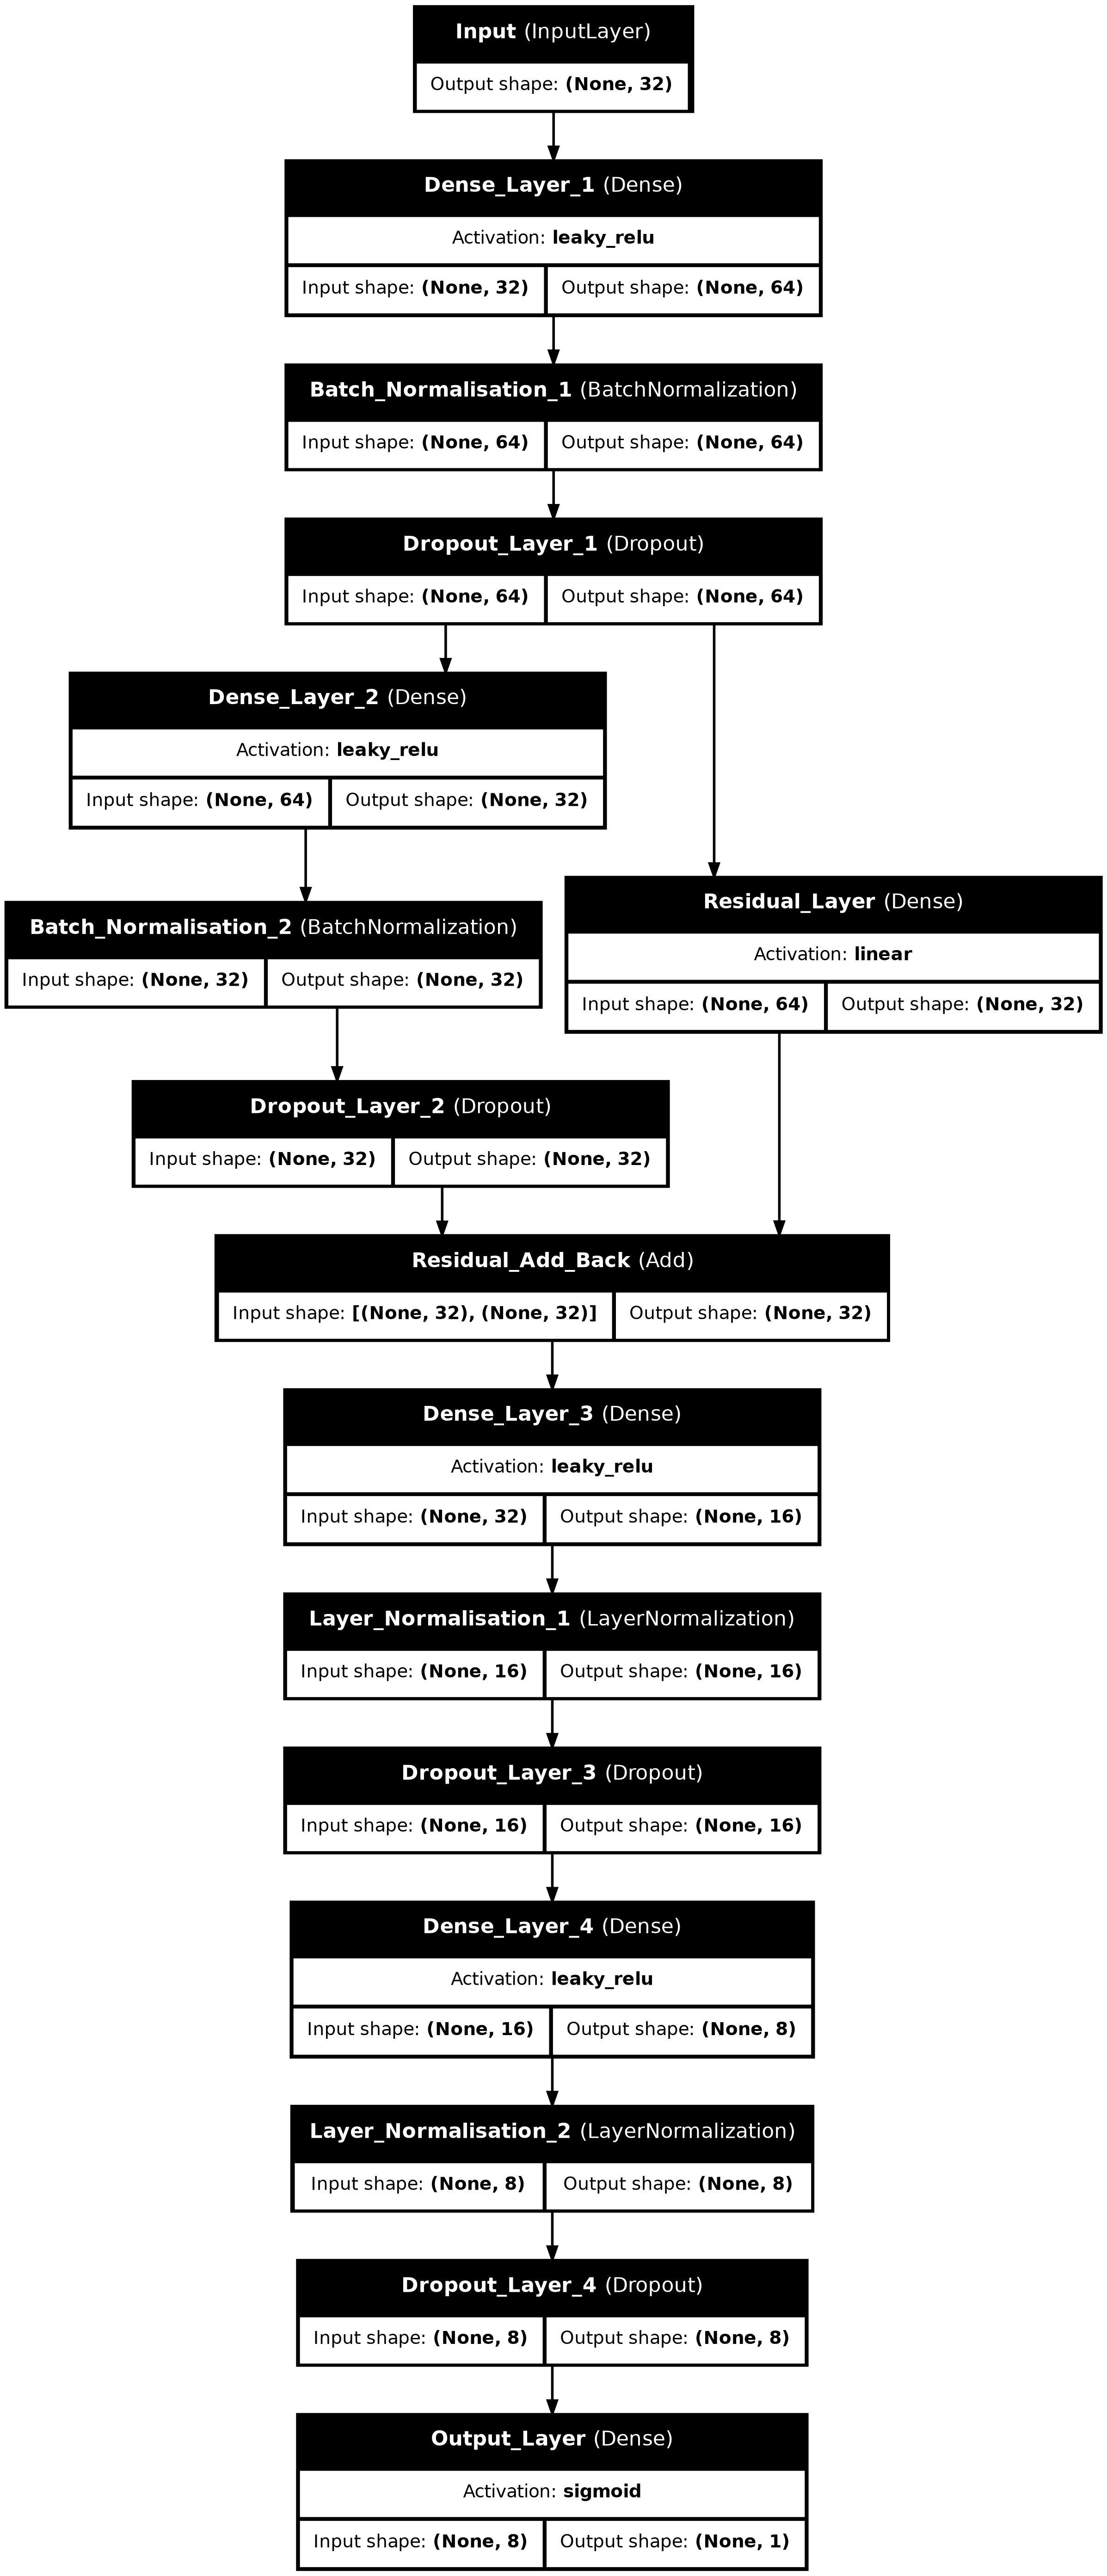

In [23]:
plot_model(
    RDP_NN,
    show_shapes=True, 
    show_layer_names=True,
    show_layer_activations=True,
)

In [24]:
## Train the Model
RDP_NN.fit(
    x = X_train,
    y = y_train,
    # validation_split=0.1, -> using 10 002 validation dataset
    validation_data=(X_test, y_test),
    shuffle = True,
    epochs=500,
    batch_size=512,
    # class_weight= class_weights, -> Not being used as the binary focal cross entropy loss function has class balancing built in.
    verbose=1,
    callbacks=[
        es,
        LRScheduler,
    ])

Epoch 1/500


I0000 00:00:1738056411.389540  588638 service.cc:148] XLA service 0x7f1a24018130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738056411.389589  588638 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-01-28 11:26:51.503296: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738056412.239790  588638 cuda_dnn.cc:529] Loaded cuDNN version 90300


 18/908 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.5847 - loss: 0.1318 - precision: 0.4233 - recall: 0.5919  

I0000 00:00:1738056416.519380  588638 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


908/908 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - binary_accuracy: 0.6510 - loss: 0.0803 - precision: 0.4836 - recall: 0.6247 - val_binary_accuracy: 0.7655 - val_loss: 0.0349 - val_precision: 0.6413 - val_recall: 0.6731 - learning_rate: 1.0000e-04
Epoch 2/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.7061 - loss: 0.0407 - precision: 0.5487 - recall: 0.6684 - val_binary_accuracy: 0.7529 - val_loss: 0.0331 - val_precision: 0.6066 - val_recall: 0.7364 - learning_rate: 1.0000e-04
Epoch 3/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.7274 - loss: 0.0357 - precision: 0.5744 - recall: 0.7126 - val_binary_accuracy: 0.7550 - val_loss: 0.0322 - val_precision: 0.6098 - val_recall: 0.7364 - learning_rate: 1.0000e-04
Epoch 4/500
908/908 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - binary_accuracy: 0.7450 - loss: 0.0335 - precision: 0.5944 - recall: 0.7361 - val_binary_accuracy: 0.7590 - val_loss: 0.0315 - val_precision: 0.6169 - val_recall: 0.7313 - learning_rate: 1.0000e-0

# Save the model

In [37]:
# Save Model
# RDP_NN.save('models_test/BinaryNN_FocalBCE.keras')

In [ ]:
#Load model 
RDP_NN = tf.keras.models.load_model('models_test/BinaryNN_FocalBCE.keras')

# Evaluate The Model


In [39]:
RDPPreds = pd.read_csv("models_test/RDPdep_preds.csv", sep=",", index_col=False)

Evaluation on 'unseen' test test
520/520 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

      Parent     0.8555    0.7835    0.8179     11078
 Recombinant     0.6294    0.7353    0.6783      5539

    accuracy                         0.7675     16617
   macro avg     0.7425    0.7594    0.7481     16617
weighted avg     0.7801    0.7675    0.7714     16617



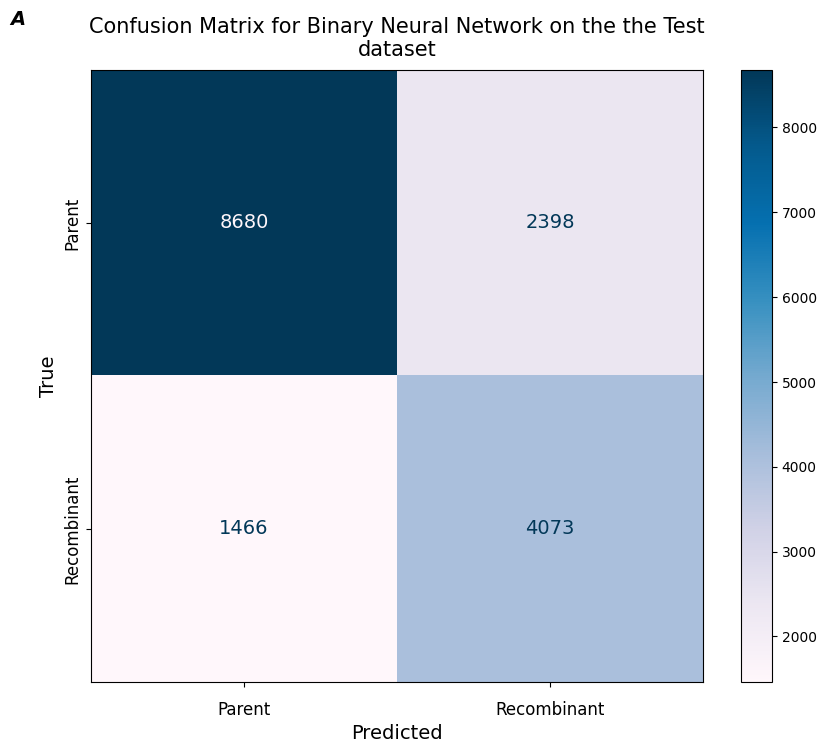

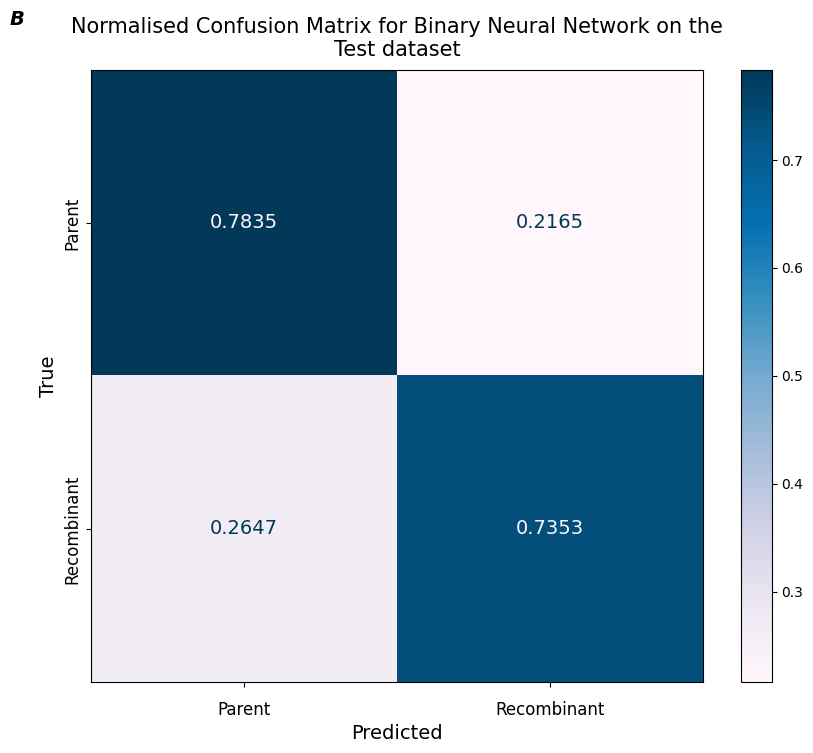

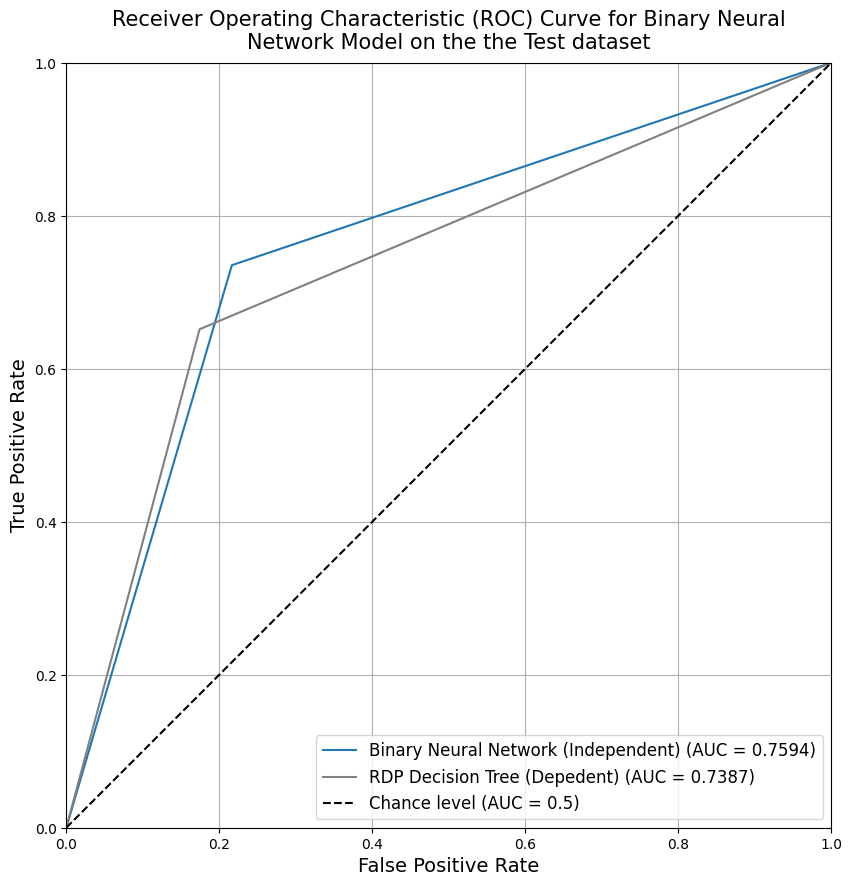

In [40]:
print("Evaluation on 'unseen' test test")
NN_Probs = RDP_NN.predict(X_unseen)
# NN_Probs = NN_Probs[:, 0]
y_preds = list(map(lambda x: 0 if x < 0.5 else 1, NN_Probs))

#Classification Report
class_report(y_true=y_unseen, y_preds=y_preds)

# Use standard confusion matrix function 
disp, ax = StdConfMatrix(y_unseen, y_preds, figure_number='A')
title = "Confusion Matrix for Binary Neural Network on the the Test dataset"
wrapped_title = textwrap.fill(title, width=64)
ax.set_title(wrapped_title, pad=10, size=15) 
plt.show()

# Use standard confusion matrix function 
disp, ax = StdConfMatrix(y_unseen, y_preds, normalise='true', format='.4f', figure_number='B')
title = "Normalised Confusion Matrix for Binary Neural Network on the Test dataset"
wrapped_title = textwrap.fill(title, width=64)
ax.set_title(wrapped_title, pad=10, size=15) 
plt.show()


# ROC Curve
title = "Receiver Operating Characteristic (ROC) Curve for Binary Neural Network Model on the the Test dataset"
wrapped_title = textwrap.fill(title, width=68)
# Assuming y_probs1 and y_probs2 are the two sets of probability predictions
fig, ax = StdRocCurve(
    y_true=y_unseen,
    y_probs_list=[y_preds,RDPPreds],
    model_names=["Binary Neural Network (Independent)", "RDP Decision Tree (Depedent)"],
    colors=['#1f77b4', '#808080'],
)
ax.set_title(wrapped_title, pad=10, size=15)
plt.show()

In [41]:
#Make dependant predictions - only take the index of the most confident choice from the triplet. 
NN_Probs = RDP_NN.predict(X_unseen)
NN_Probs = NN_Probs[:, 0]
dep_preds = pd.Series()

for i in range(0, len(NN_Probs), 3):
    triplet = pd.Series(data = [NN_Probs[i], NN_Probs[i+1], NN_Probs[i+2]])
    indx = triplet.idxmax()
    new = pd.Series([0, 0, 0], index=[i, i+1, i+2])
    new.loc[i+indx] = 1
    dep_preds = pd.concat([dep_preds, new], ignore_index=False)

520/520 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/tmp/ipykernel_588450/1360979660.py:14: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  dep_preds = pd.concat([dep_preds, new], ignore_index=False)


In [42]:
dep_preds.to_csv('models_test/BNNdep_preds.csv', sep=",", index=False)

Dependent predictions on the 'Unseen' test set
              precision    recall  f1-score   support

      Parent     0.8424    0.8424    0.8424     11078
 Recombinant     0.6848    0.6848    0.6848      5539

    accuracy                         0.7899     16617
   macro avg     0.7636    0.7636    0.7636     16617
weighted avg     0.7899    0.7899    0.7899     16617



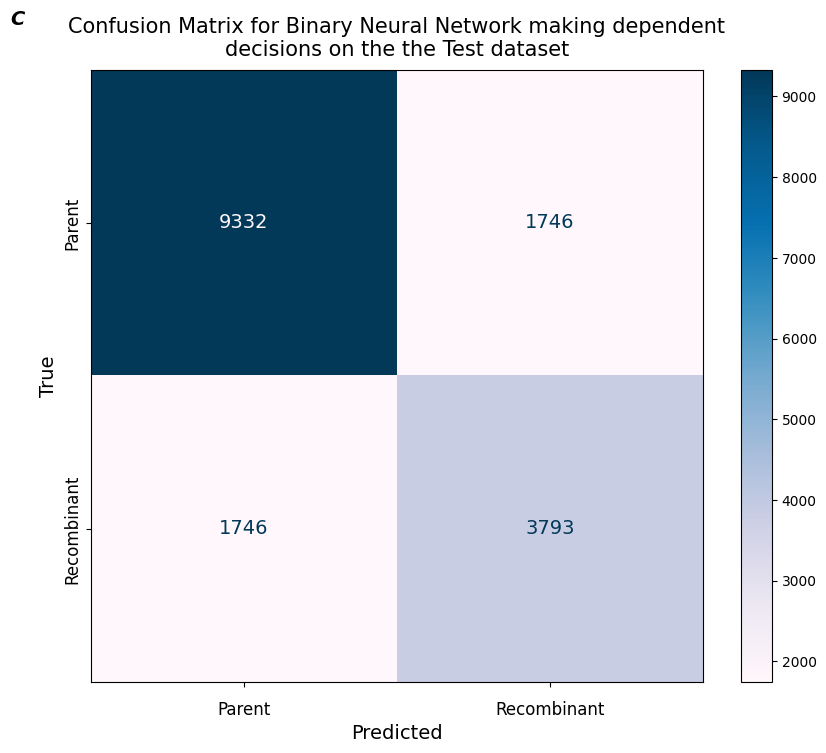

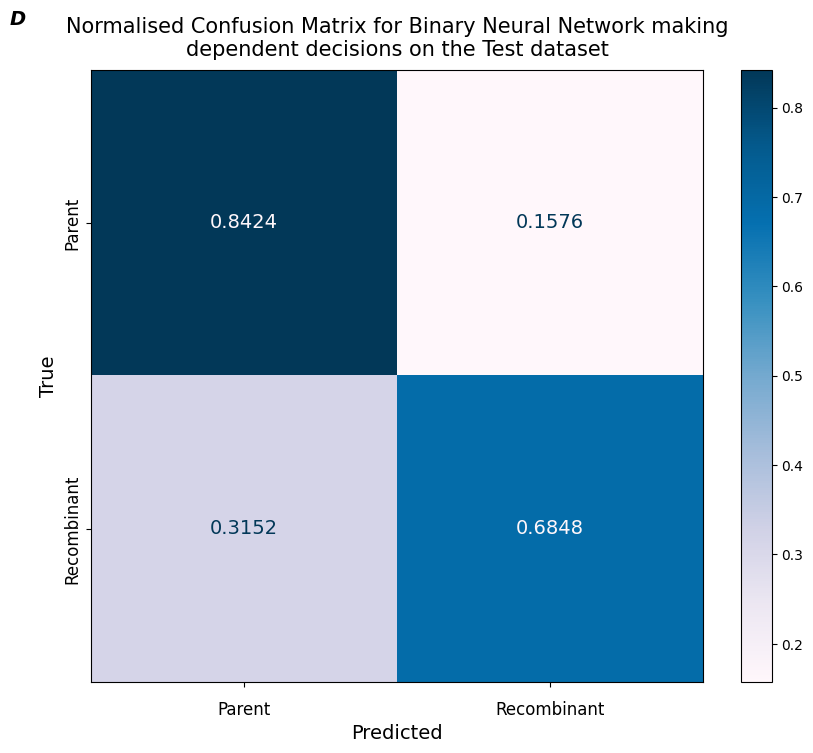

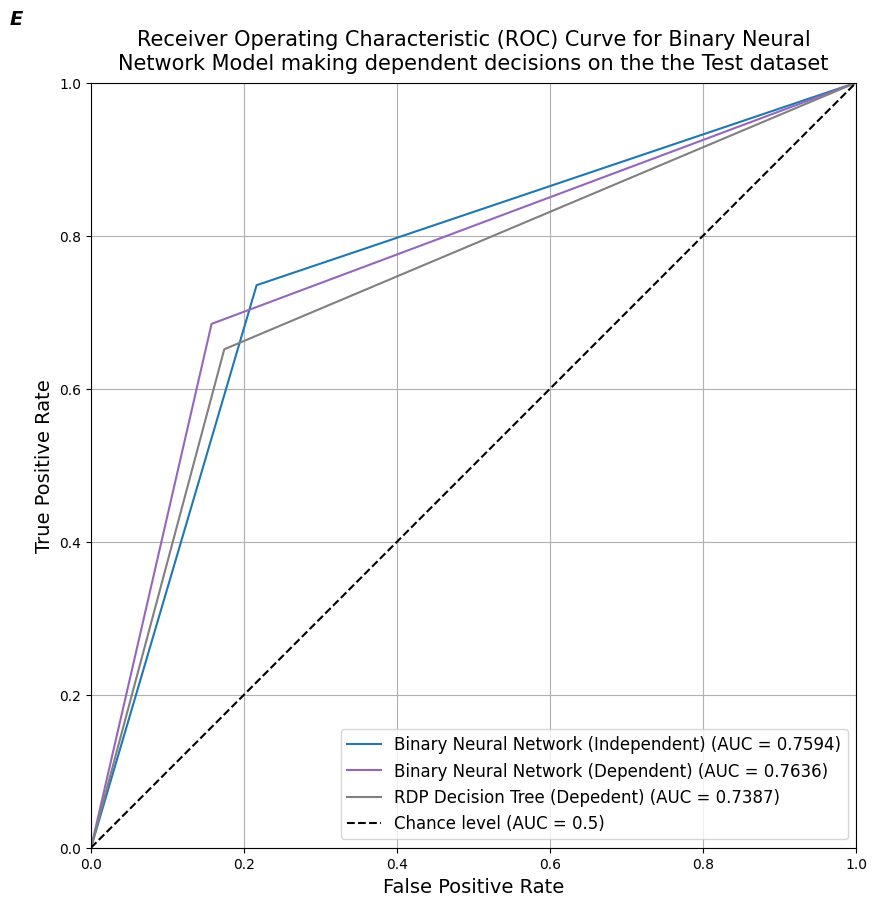

In [43]:
print("Dependent predictions on the 'Unseen' test set")

#Classification Report
class_report(y_true=y_unseen, y_preds=dep_preds)

# Use standard confusion matrix function 
disp, ax = StdConfMatrix(y_unseen, dep_preds, figure_number='C')
title = "Confusion Matrix for Binary Neural Network making dependent decisions on the the Test dataset"
wrapped_title = textwrap.fill(title, width=64)
ax.set_title(wrapped_title, pad=10, size=15) 
plt.show()

disp, ax = StdConfMatrix(y_unseen, dep_preds, normalise='true', format='.4f', figure_number='D')
title = "Normalised Confusion Matrix for Binary Neural Network making dependent decisions on the Test dataset"
wrapped_title = textwrap.fill(title, width=64)
ax.set_title(wrapped_title, pad=10, size=15) 
plt.show()

# ROC Curve
title = "Receiver Operating Characteristic (ROC) Curve for Binary Neural Network Model making dependent decisions on the the Test dataset"
wrapped_title = textwrap.fill(title, width=68)
# Assuming y_probs1 and y_probs2 are the two sets of probability predictions
fig, ax = StdRocCurve(
    y_true=y_unseen,
    y_probs_list=[y_preds, dep_preds, RDPPreds],
    model_names=["Binary Neural Network (Independent)","Binary Neural Network (Dependent)", "RDP Decision Tree (Depedent)"],
    figure_number='E',
    colors=['#1f77b4','#9467bd', '#808080'],
)
ax.set_title(wrapped_title, pad=10, size=15)
plt.show()